# Bootstrap imputer

## Idea

Missing values are often imputed with the mean or median, because it is the best guess. 

Instead, I thought to create an imputer that draws a random value from the distribution of the variable, bootstrapping. It also relates to Bayesian modelling. The advantage I recognized was that once all values are imputed, the imputed feature has the same distribution as the original feature (albeit with some values missing). When the mean or median is used to impute, the distribution obviously is more peaked; many values at the median or mean value, thereby also adjusting other statistics, e.g. standard deviation. 

The mean or median imputed feature performs better in a regression though.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import seaborn as sns

from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.base import TransformerMixin
from sklearn.datasets import make_regression

In [2]:
class BootstrapImputer(TransformerMixin):
    def __init__(self, random_state=None):
        # todo: add random state
        super().__init__()
        self.mem = dict()
        
    def fit(self, X: pd.DataFrame, y=None):
        for c in X.columns:
            self.mem[c] = dict(X[c].value_counts())
        return self
    
    def transform(self, X: pd.DataFrame):
        X_copy = X.copy()
        for c in X_copy.columns:
            p = np.array([*(self.mem[c].values())])
            random_replacements = np.random.choice(
                list(self.mem[c].keys()), 
                size=X_copy.shape[0], 
                p=p/p.sum(),
            )
            isna_mask = X_copy.loc[:, c].isna()
            X_copy.loc[isna_mask, c] = random_replacements[isna_mask]
        return X_copy.values

In [3]:
n = 10000

In [4]:
X, y, coefs = make_regression(
    n_samples=n,
    n_features=3, 
    n_informative=1,
    n_targets=1,
    bias=10,
    coef=True,
    noise=50,
    random_state=0,
)

In [5]:
coefs

array([ 0.        , 79.94907627,  0.        ])

In [6]:
dfX = pd.DataFrame(X, columns=[f'x_{i}' for i in range(X.shape[1])])
dfy = pd.DataFrame(y, columns=['y'])
df = dfX.join(dfy)
df.head()

,x_0,x_1,x_2,y
0,0.199479,-0.855201,-0.796763,-23.152322
1,1.252002,1.384187,-1.144693,112.703167
2,-0.477076,-0.404238,-0.156454,-95.336396
3,-0.372357,1.671047,-0.093511,153.678285
4,-0.524939,1.901340,0.274417,206.830825


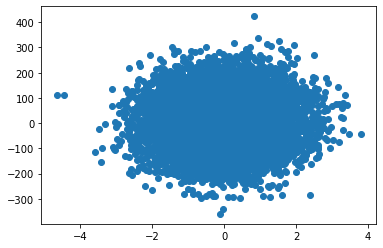

In [7]:
# plot data
plt.scatter(x=df['x_0'], y=df['y'])

In [8]:
prep1 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
])
prep2 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
])
prep3 = Pipeline(steps=[
    ('imputer', BootstrapImputer()),
])

pipe1 = Pipeline(steps=[
    ('prep', prep1),
    ('scaler', StandardScaler()),
    ('model', LinearRegression()),
])

pipe2 = Pipeline(steps=[
    ('prep', prep2),
    ('scaler', StandardScaler()),
    ('model', LinearRegression()),
])

pipe3 = Pipeline(steps=[
    ('prep', prep3),
    ('scaler', StandardScaler()),
    ('model', LinearRegression()),
])

In [9]:
features = df.columns[:-1]
target = df.columns[-1]

X = df.loc[:, features]
y = df.loc[:, [target]]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [10]:
model = sm.OLS(y_train, sm.add_constant(prep1.fit_transform(X_train)))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     6386.
Date:                Wed, 17 Aug 2022   Prob (F-statistic):               0.00
Time:                        17:11:27   Log-Likelihood:                -39995.
No. Observations:                7500   AIC:                         8.000e+04
Df Residuals:                    7496   BIC:                         8.002e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.0932      0.579     17.446      0.0

In [11]:
# introduce missing values
fraction_remove = 0.2
for col in features:
    remove_idx = list(np.random.randint(n, size=int(fraction_remove * n)))
    df.loc[remove_idx, col] = np.nan

In [12]:
df.describe()

,x_0,x_1,x_2,y
count,8185.000000,8200.000000,8191.000000,10000.000000
mean,-0.002124,-0.006353,-0.009472,9.854658
std,0.993675,0.989886,0.990338,93.641016
min,-4.659953,-3.694285,-3.740101,-359.852922
25%,-0.670107,-0.669846,-0.672324,-53.428216
50%,-0.008266,-0.000449,-0.015491,8.264379
75%,0.668735,0.654424,0.658584,73.863270
max,3.801660,3.427539,3.831790,423.648621


[]

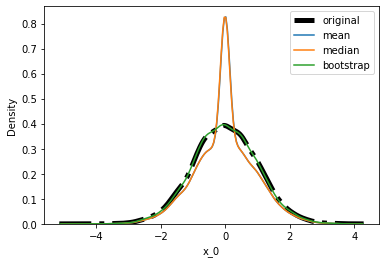

In [13]:
feat = 'x_0'

sns.kdeplot(df.loc[:, feat], linestyle='-.', linewidth=5, color='black', label='original')
for name, preprocessing in zip(['mean', 'median', 'bootstrap'], [prep1, prep2, prep3]):
    sns.kdeplot(preprocessing.fit_transform(df.loc[:, [feat]]).flatten(), label=name)
plt.legend()
plt.plot()

In [14]:
X = df.loc[:, features]
y = df.loc[:, [target]]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [72]:
for name, pipe in zip(['mean', 'median', 'bootstrap'], [pipe1, pipe2, pipe3]):
    print(name)
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    
    print(mse, mae)

mean
4007.909950433162 47.528487242142674
median
4007.3858178142973 47.52505720757076
bootstrap
4647.668025873792 50.77805537733406
